## LOG
#### [09/05/2020] 
- progress: completing training loop
- issues: TrainEvalCallback turns model into eval mode. It is not desired because torchvision.FasterRCNN has different behavior at eval mode
- issues: friction integrating metrics into the training loop
- issues: default datablock is not really suitable for torchvision.FasterRCNN

#### [10/05/2020]
- minor issue: train.json has duplicates dict in key 'images'

#### [17/05/2020]
- metrics has been integrated in training loop
- changed to RetinaNet from torchvision.FasterRCNN
- some data has a large bboxes

**Questions**
- in dls.show_batch, how to augment image_id on plot?
- how TensorBBox is transforms in batch?
- why RetinaNet classifier score is negative (no matter class = 1 OR 2)

In [1]:
import os
import sys
path = os.path.join(os.getcwd(), '..')
sys.path.append(path)

import warnings 
warnings.filterwarnings("ignore")

from fastai2.vision.all import *

from src.data.dblock import build_dblock
from src.data.dls import build_dataloaders
from src.model.model import get_retinanet, split_param_groups
from src.metrics.loss import get_retinanet_loss
from src.metrics.mAP import mAP

%load_ext autoreload
%autoreload 2

In [2]:
from pdb import set_trace

In [3]:
data_path = '/userhome/34/h3509807/wheat-data'

#### -1. Sanity Check ```train.json```

In [7]:
from src.data.utils import decode_coco_json

In [8]:
json_path = Path(data_path) / 'train_mini.json'
img_ids, lbl_bbox, img2bbox = decode_coco_json(json_path)

In [9]:
len(img_ids), len(lbl_bbox), len(img2bbox)

(120, 120, 120)

#### 1a. Get DataBlock

In [10]:
dblk = build_dblock(Path(data_path), resize_sz = 256, 
                    norm = True, rand_seed = 144, test_mode = False)

In [11]:
ds = dblk.datasets(data_path + '/train')

In [12]:
xx = ds[0]
type(xx[0]), xx[0].shape, type(xx[1])

(fastai2.vision.core.PILImage, (1024, 1024), fastai2.vision.core.TensorBBox)

#### 1b. Get DataLoaders

In [4]:
dls = build_dataloaders(
    data_path, bs = 8, resize_sz = 256, 
    norm = True, rand_seed = 144, test_mode = True
    )

In [5]:
len(dls.train.items), len(dls.valid.items)

(96, 24)

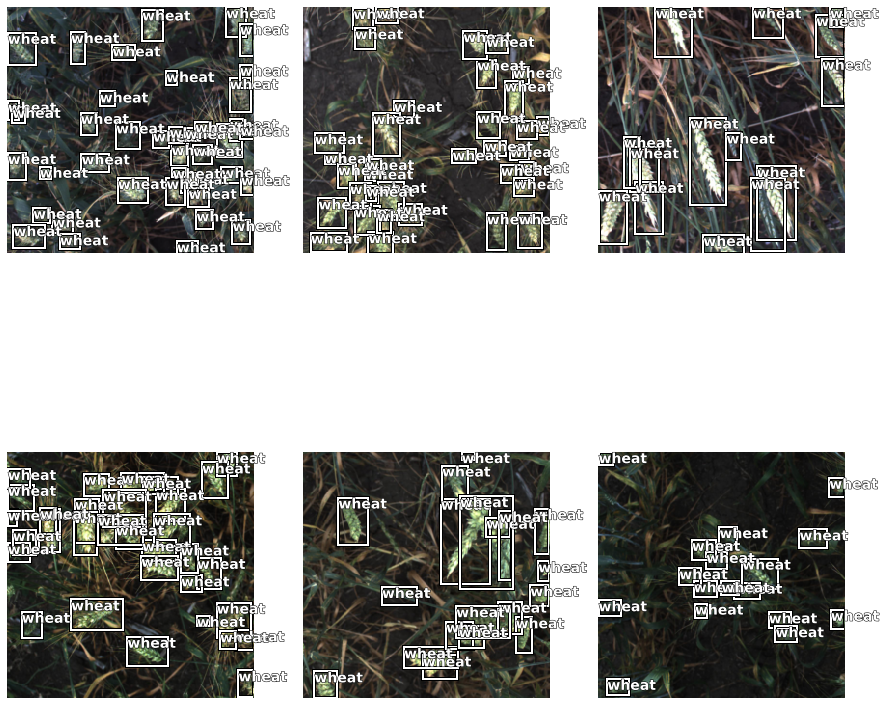

In [6]:
dls.show_batch(max_n = 6, figsize = (15, 15))

In [16]:
# batch = (TensorImage, TensorBBox, TensorMultiCategory)
# TensorBBox: [BS, MAX BBOX NUMBER, 4]
# TensorMultiCategory: [BS, MAX BBOX NUMBER]
b = dls.one_batch()
type(b), type(b[0]), type(b[1]), type(b[2])

(tuple,
 fastai2.torch_core.TensorImage,
 fastai2.vision.core.TensorBBox,
 fastai2.torch_core.TensorMultiCategory)

In [17]:
b[0].shape, b[1].shape, b[2].shape

(torch.Size([8, 3, 256, 256]), torch.Size([8, 35, 4]), torch.Size([8, 35]))

In [18]:
b[0][0, 0, :3, :3]

tensor([[0.9882, 0.8745, 0.6627],
        [0.9765, 0.8745, 0.7137],
        [0.8392, 0.6941, 0.7294]], device='cuda:0')

In [19]:
b[1][0][0]

tensor([ 0.5059, -0.5332,  0.7402, -0.4043], device='cuda:0')

In [20]:
get_c(dls)

2

#### 2. Setup Model

In [6]:
import torch.nn as nn

In [7]:
model = get_retinanet()
model = model.cuda()

In [23]:
for attr_name in dir(model):
    attr = getattr(model, attr_name)
    if isinstance(attr, nn.Module) or isinstance(attr, nn.Sequential):
        print(attr_name)

box_regressor
c5top5
c5top6
classifier
encoder
merges
p6top7
smoothers


#### 3. Setup RetinaNet Loss

In [8]:
retinanet_loss = get_retinanet_loss(ratios = None, scales = None)

In [9]:
retinanet_loss

RetinaNetFocalLoss()

#### 4a. Setup mAP for RetinaNet

In [38]:
b = dls.one_batch()
b_imgs, b_bboxs_gts, sizes = b
with torch.no_grad():
    b_preds = model(b_imgs)
b_clas_preds, b_bboxs_preds, sizes = b_preds

b_clas_preds.shape, b_clas_gts.shape

(torch.Size([8, 46836, 1]), torch.Size([8, 3, 256, 256]))

In [ ]:
clas_preds, bboxs_preds = b_clas_preds[0], b_bboxs_preds[0]
clas_gts, bboxs_gts = b_clas_gts[0], b_bboxs_gts[0]

clas_preds = clas_preds.cpu().numpy().squeeze()
bboxs_preds = bboxs_preds.cpu().numpy()
clas_gts = clas_gts.cpu().numpy()
bboxs_gts = bboxs_gts.cpu().numpy()

In [ ]:
thre_idxs = np.argwhere(clas_preds >= 0.5).squeeze()
thre_clas_preds = clas_preds[thre_idxs]
thre_bbox_preds = bboxs_preds[thre_idxs]

sort_idxs = np.argsort(-thre_clas_preds)
thre_clas_preds[sort_idxs]
bboxs_preds[sort_idxs]

#### 4b. Wrap up the Whole mMAP Metrics Function

In [42]:
from functools import partial

thresholds = [i for i in map(lambda i: i/100, range(50, 80, 5))]
thresholds

map_getter = partial(mAP, thresholds = thresholds)

#### 5a. Setup Callback

#### 5b. Change TrainEvalCallback Behavior
no need activate eval mode in validation set

#### 6. Setup Learner

In [10]:
learn = Learner(dls, model, 
                loss_func = retinanet_loss, 
                splitter = split_param_groups)
                #metrics = map_getter)

In [11]:
learn.freeze()

In [12]:
learn.summary()

RetinaNet (Input shape: ['8 x 3 x 256 x 256'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               8 x 64 x 128 x 128   9,408      False     
________________________________________________________________
BatchNorm2d          8 x 64 x 128 x 128   128        True      
________________________________________________________________
ReLU                 8 x 64 x 128 x 128   0          False     
________________________________________________________________
MaxPool2d            8 x 64 x 64 x 64     0          False     
________________________________________________________________
Conv2d               8 x 64 x 64 x 64     36,864     False     
________________________________________________________________
BatchNorm2d          8 x 64 x 64 x 64     128        True      
________________________________________________________________
ReLU                 8 x 64 x 64 x 64     0          False     
___________________________________________________

#### 7. Find Optimal Learning Rate

SuggestedLRs(lr_min=0.00012022644514217973, lr_steep=3.0199516913853586e-05)

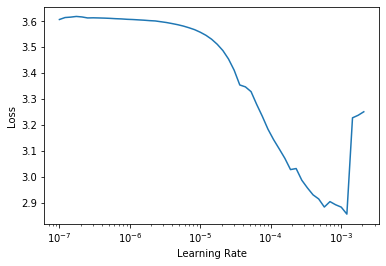

In [13]:
learn.lr_find()

#### 8. Train The Head

In [14]:
lr = 1e-4
learn.fit_one_cycle(20, lr)

epoch,train_loss,valid_loss,time
0,3.475702,3.221045,00:13
1,3.074773,2.226086,00:13
2,2.636614,1.827166,00:13
3,2.322700,1.748394,00:13
4,2.058702,1.371508,00:13
5,1.844203,1.268412,00:13
6,1.686278,1.236675,00:13
7,1.549247,1.136884,00:13
8,1.430910,1.078472,00:13
9,1.337482,1.067303,00:13


#### 9. Find Optimal Learning Rate for Fine-tuning

In [15]:
learn.unfreeze()

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=1.3182567499825382e-06)

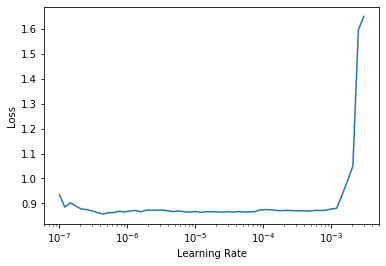

In [16]:
learn.lr_find()

#### Appendix

In [38]:
# learn.create_opt()
# learn.opt.freeze_to(-1) # freeze except last param groups
# learn.opt.param_groups[-1]
# learn.opt.freeze_to(-2) # freeze except last two param groups
# learn.opt.param_groups[-2]